In [1]:
import mne
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import os.path as op
import seaborn as sns
from scipy import signal
from math import floor
from scipy.fft import fftshift
from bids import BIDSLayout
from mne_bids import BIDSPath, read_raw_bids

## Plot cz

In [2]:
files = glob.glob('../data/bids/derivatives/preprocess_ffr/sub-*/*fif.gz')
epochs = None
for i, file in enumerate(files):
    sub = re.findall('sub-(\d{1,2})', file)[0]
    if int(sub) in [2, 3, 4, 5, 6, 7, 8, 9, 10, 33, 37]:
        continue

    sub_epochs = mne.read_epochs(file)
    if epochs == None:
        epochs = sub_epochs
    else:
        epochs = mne.concatenate_epochs([epochs, sub_epochs])
    # break

Reading /project/hcn1/Letty/pitch_tracking_attention/analysis/../data/bids/derivatives/preprocess_ffr/sub-23/sub-23_task-pitch_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -250.00 ...     250.00 ms
        0 CTF compensation matrices available
Not setting metadata
4002 matching events found
No baseline correction applied
0 projection items activated
Reading /project/hcn1/Letty/pitch_tracking_attention/analysis/../data/bids/derivatives/preprocess_ffr/sub-23/sub-23_task-pitch_run-1_desc-forFFR2_epo.fif.gz ...
    Found the data of interest:
        t =    -250.00 ...     250.00 ms
        0 CTF compensation matrices available
Not setting metadata
4002 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
8004 matching events found
Applying baseline correction (mode: mean)
Reading /project/hcn1/Letty/pitch_tracking_attention/analysis/../data/bids/derivatives/preprocess_ffr/sub-28/sub-28_task-pitch_run-1_de

In [8]:
epochs # 1 = 130, 2 = 200, 3 = 280 Hz

Number of events,216946
Events,11: 2237212: 2378813: 2381621: 2478422: 2338423: 2439431: 2497232: 2496633: 24470
Time range,-0.250 – 0.250 s
Baseline,-0.250 – 0.000 s


In [9]:
# Adjust timestamp by computed event lag
lag_msec = 26.8
lag_sec = lag_msec/1000 # sec, from timing-test.ipynb in task folder
fs = 1200
lag_steps = floor(lag_sec*fs)

def plot_time_domain_ffr(epochs, tone, tags, t, lag_steps):
    # Compute evokeds
    ffr = epochs[tags].average().get_data()
    ffr = ffr*1000000 # convert to uV
    ffr = ffr.tolist()[0]
    ffr = ffr[lag_steps:]

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(t, ffr, color = 'black', linewidth = 0.8)
    # plt.ylim(-0.52, 0.52)
    plt.xlabel('msec')
    plt.ylabel('uV')
    plt.title(f'{tone} Hz')
    # plt.savefig(f'figs/FFR-{tone}hz.png', dpi = 300)
    plt.show()

t = np.arange(-250-lag_msec, 250.5-lag_msec, 1000/fs)
t = t[lag_steps:]
plot_time_domain_ffr(epochs, 130, ['11', '21', '31'], t, lag_steps)
plot_time_domain_ffr(epochs, 200, ['12', '22', '32'], t, lag_steps)
plot_time_domain_ffr(epochs, 280, ['13', '23', '33'], t, lag_steps)

Need more than one channel to make topography for eeg. Disabling interactivity.


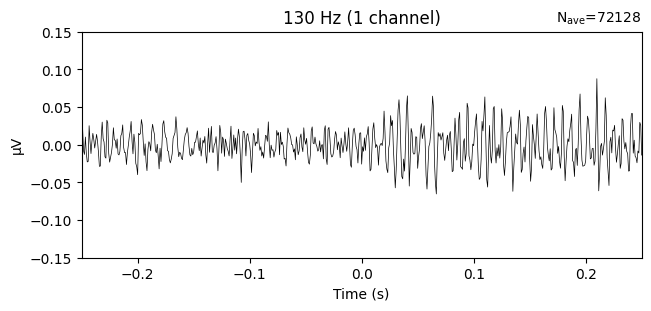

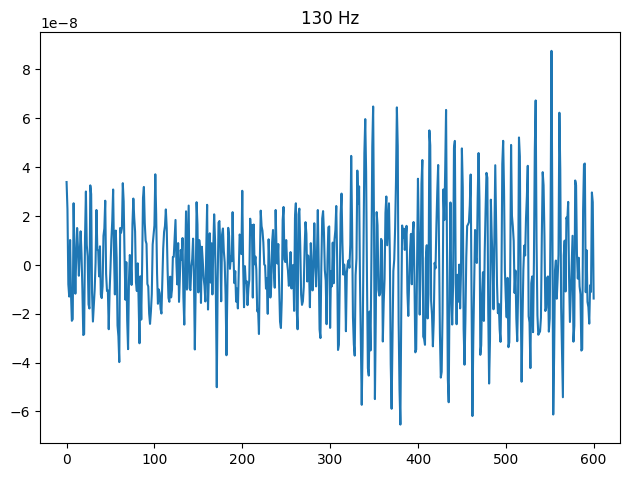

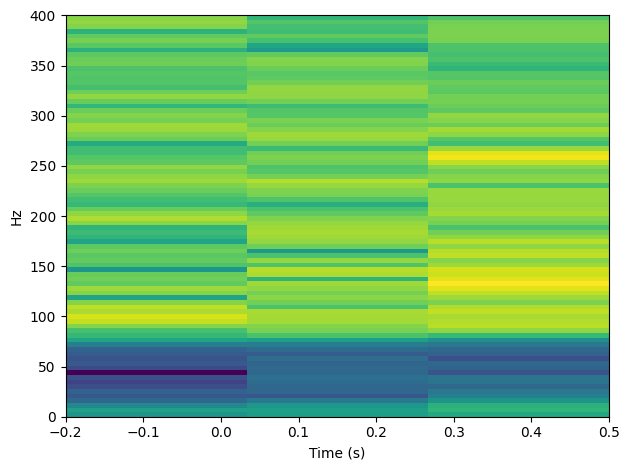

In [10]:
# cz_130 = epochs['11', '21', '31'].average()
# fig = cz_130.plot(titles = '130 Hz', ylim=dict(eeg=[-0.15, 0.15]))
# # fig.savefig('../figs/FFR-tone-1-time-domain.png')
# x = cz_130.get_data()
# x = x.flatten()
# plt.plot(x)
# plt.tight_layout()
# # plt.savefig('../figs/FFR-tone-1-time-domain-2.png')
# plt.title('130 Hz')
# plt.show()
# powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(x, Fs= fs, xextent = (-0.2, 0.5))
# plt.ylim(0, 400)
# plt.xlabel('Time (s)')
# plt.ylabel('Hz')
# plt.tight_layout()
# # plt.savefig('../figs/FFR-tone-1-spectrogram.png')
# plt.show()

## Plot raw aux

In [3]:
fs = 1200
TMIN = -0.5
TMAX = 0.5
files = glob.glob('../data/raw/*.vhdr')
aux_epochs = []
limit = 5

for i, file in enumerate(files):
    sub = re.findall('sub-(\d{1,2})', file)[0]

    # Read raw data
    raw = mne.io.read_raw_brainvision(file)

    # Save only aux channel
    raw.set_channel_types({'Aux1': 'eeg'})
    raw = raw.pick_channels(['Aux1'])

    # Fix event tags
    events, event_ids = mne.events_from_annotations(raw)
    events = events[events[:,2] != event_ids['New Segment/'], :]
    # events[:,0] = events[:,0] + 500 # Fix timestamp
    annot = mne.annotations_from_events(events, sfreq = raw.info['sfreq'])
    raw = raw.set_annotations(annot)

    # Epoch
    sub_aux_epochs = mne.Epochs(
        raw,
        events,
        tmin = TMIN,
        tmax = TMAX,
        baseline = (TMIN, 0.),
        preload = True
    )

    if aux_epochs == []:
        aux_epochs = sub_aux_epochs
    else:
        aux_epochs = mne.concatenate_epochs([aux_epochs, sub_aux_epochs])

    if i == limit:
        break
    # break

Extracting parameters from ../data/raw/pta_sub-22.vhdr...
Setting channel info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']
Not setting metadata
3492 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3492 events and 5001 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/raw/pta_sub-23.vhdr...
Setting channel info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']
Not setting metadata
4044 matching events found
App

/scratch/local/jobs/22979381/ipykernel_512189/3068695847.py:38: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  aux_epochs = mne.concatenate_epochs([aux_epochs, sub_aux_epochs])


Extracting parameters from ../data/raw/pta_sub-21.vhdr...
Setting channel info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']
Not setting metadata
3774 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3774 events and 5001 original time points ...
0 bad epochs dropped


/scratch/local/jobs/22979381/ipykernel_512189/3068695847.py:38: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  aux_epochs = mne.concatenate_epochs([aux_epochs, sub_aux_epochs])


Not setting metadata
11310 matching events found
Applying baseline correction (mode: mean)
Extracting parameters from ../data/raw/pta_sub-25.vhdr...
Setting channel info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']
Not setting metadata
3762 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3762 events and 5001 original time points ...
0 bad epochs dropped


/scratch/local/jobs/22979381/ipykernel_512189/3068695847.py:38: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  aux_epochs = mne.concatenate_epochs([aux_epochs, sub_aux_epochs])


Not setting metadata
15072 matching events found
Applying baseline correction (mode: mean)
Extracting parameters from ../data/raw/pta_sub-20.vhdr...
Setting channel info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']
Not setting metadata
3636 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3636 events and 5001 original time points ...
0 bad epochs dropped


/scratch/local/jobs/22979381/ipykernel_512189/3068695847.py:38: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  aux_epochs = mne.concatenate_epochs([aux_epochs, sub_aux_epochs])


Not setting metadata
18708 matching events found
Applying baseline correction (mode: mean)
Extracting parameters from ../data/raw/pta_sub-24.vhdr...
Setting channel info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 33']
Not setting metadata
4086 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 4086 events and 5001 original time points ...
0 bad epochs dropped


/scratch/local/jobs/22979381/ipykernel_512189/3068695847.py:38: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  aux_epochs = mne.concatenate_epochs([aux_epochs, sub_aux_epochs])


Not setting metadata
22794 matching events found
Applying baseline correction (mode: mean)


In [4]:
aux_epochs

Number of events,22794
Events,11: 239312: 252713: 252021: 235922: 228923: 245631: 278432: 281633: 2650
Time range,-0.500 – 0.500 s
Baseline,-0.500 – 0.000 s


In [11]:
# Adjust timestamp by computed event lag
tmin_msec = -500
tmax_msec = 500
lag_msec = 20
lag_sec = lag_msec/1000 # sec, from timing-test.ipynb in task folder
fs = 5000
lag_steps = floor(lag_sec*fs)
t = np.arange(tmin_msec-lag_msec, tmax_msec-lag_msec+0.2, 1000/fs)
t = t[lag_steps:]

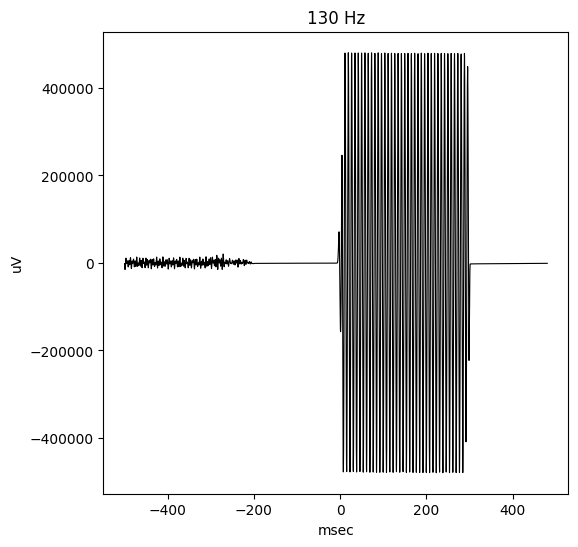

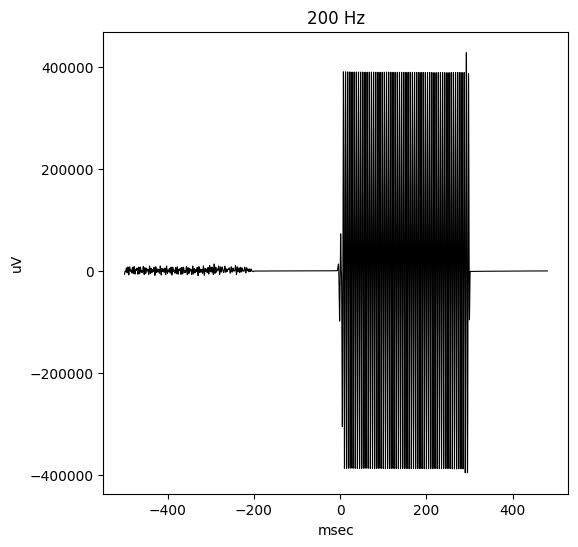

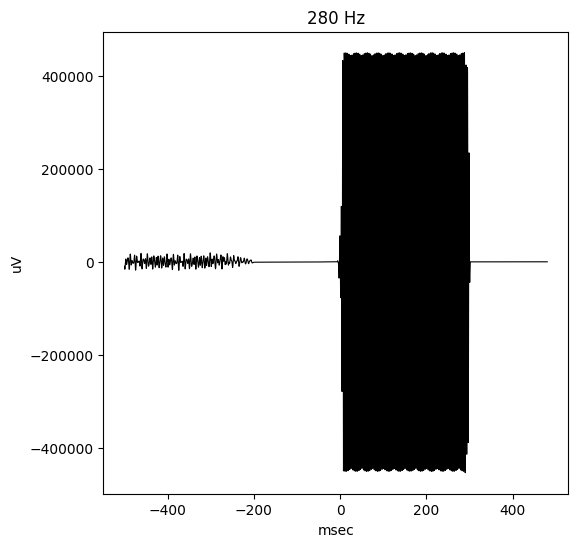

In [12]:
plot_time_domain_ffr(aux_epochs, 130, ['11', '21', '31'], t, lag_steps)
plot_time_domain_ffr(aux_epochs, 200, ['12', '22', '32'], t, lag_steps)
plot_time_domain_ffr(aux_epochs, 280, ['13', '23', '33'], t, lag_steps)

### Plot mulitple AUX events

In [67]:
# constants
BIDS_ROOT = '../data/bids'
DERIV_ROOT = op.join(BIDS_ROOT, 'derivatives')
TASK = 'pitch'
run = '1'
sub = '18'

In [68]:
# load data
bids_path = BIDSPath(
    root = BIDS_ROOT,
    subject = sub,
    task = TASK,
    run = run,
    datatype = 'eeg'
    )
raw = read_raw_bids(bids_path, verbose = False)
events, event_ids = mne.events_from_annotations(raw)
raw = raw.set_channel_types({'Aux1': 'stim'})
raw = raw.pick_channels(['Aux1'])

Used Annotations descriptions: ['11', '12', '13', '21', '22', '23', '31', '32', '33']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/scratch/local/jobs/22999750/ipykernel_215216/1495664048.py:9: RuntimeWarning: The unit for channel(s) Aux1 has changed from NA to V.
  raw = read_raw_bids(bids_path, verbose = False)
/scratch/local/jobs/22999750/ipykernel_215216/1495664048.py:9: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/scratch/local/jobs/22999750/ipykernel_215216/1495664048.py:9: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


**Plot using MNE**

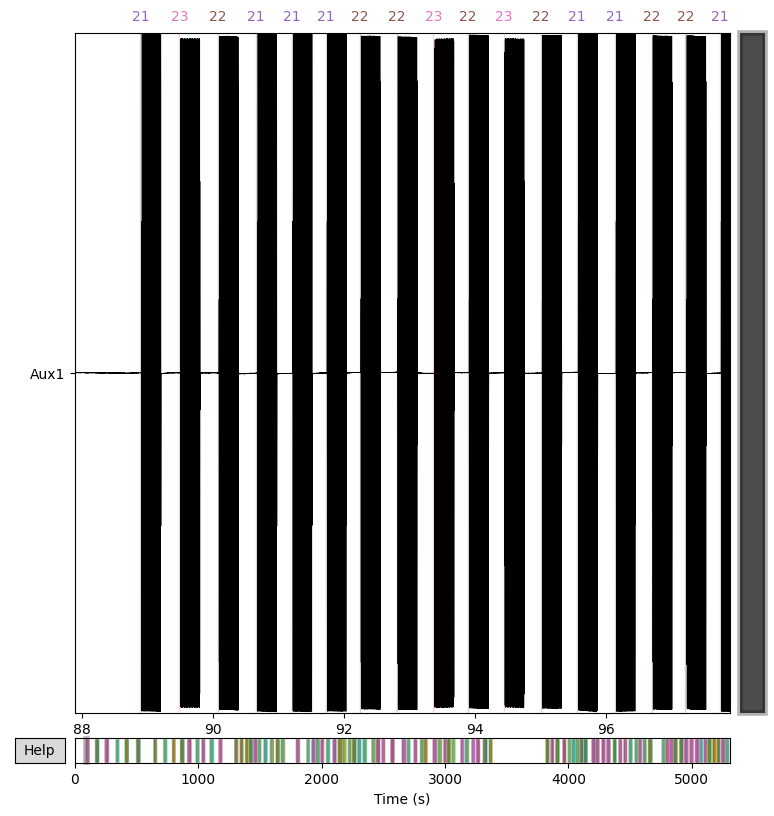

In [70]:
fs = 5000

# Get time of first event
event_1 = events[[0]][0][0]/fs 

# Plot using mne
raw.plot(start = event_1-1, duration = 10)
plt.show()

**Sanity check, plot manually using matplotlib**

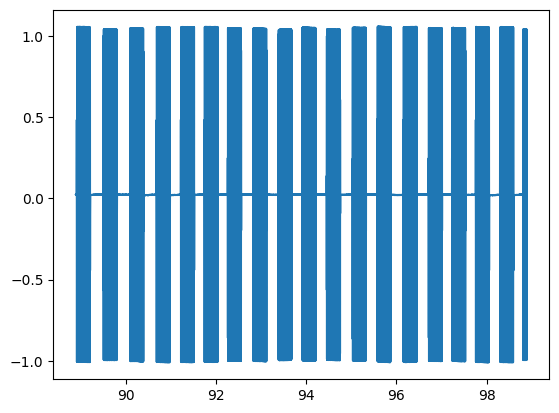

In [103]:
# Get sample number of first event
seg_start = int(event_1*fs)

# Get first 10 seconds following first event
dur = 10*fs
seg_stop = int(seg_start + dur)
raw_seg = raw.get_data(start = seg_start, stop = seg_stop)
raw_seg = np.squeeze(raw_seg)

# Plot
t = np.arange(seg_start/fs, seg_stop/fs, 1/fs) # in sec
plt.plot(t, raw_seg)

**Get distribution of ISIs**

In [79]:
events_sec = events[:, 0]/5000
durs = np.diff(events_sec)
durs = durs[durs < 4]

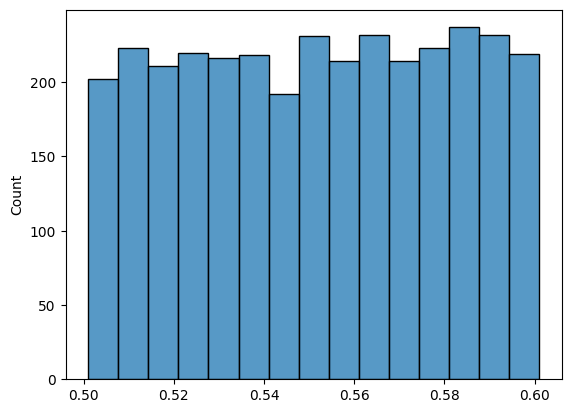

In [80]:
sns.histplot(durs.tolist())
plt.show()

**Manually find stim durations and ISI**

In [132]:
thres = 0.1
steps = []

def save_next_val(seg, thres, find_higher):
    power_seg = abs(seg).mean()
    if power_seg > thres and find_higher: # If you're looking for stim onset time
        return True
    if power_seg < thres and not find_higher: # If you're looking for stim offset time
        return True

# Get sample number of first event
seg_start = int(event_1*fs)

# Get first 20 seconds following first event
dur = 20*fs
seg_stop = int(seg_start + dur)
raw_seg = raw.get_data(start = seg_start, stop = seg_stop)
raw_seg = np.squeeze(raw_seg)

find_higher = True
for step, value in enumerate(raw_seg):
    seg = raw_seg[step:step+10]
    # print(seg)
    if save_next_val(seg, thres, find_higher):
        steps.append(step-10)
        find_higher = not find_higher # Flip what you're looking for


<AxesSubplot: ylabel='Count'>

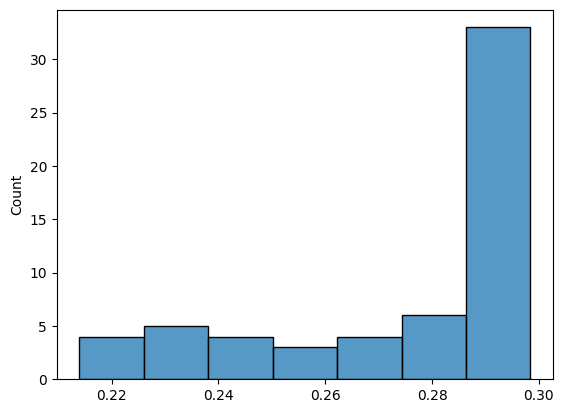

In [133]:
# Plot the intervals, one sharp peak should represent the stim duration, seems right, stim duration is 300 msec
diffs = np.diff(steps)/5000
sns.histplot(diffs.tolist())